# **Import Modules & Libraries**

In [ ]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
# Using TensorBoard in PyTorch
from tensorflow import summary

In [ ]:
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)

# **Data Preparation**

In [ ]:
def prepare_data(batch_size):
  # transform to normalize the data
  transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
  
  # Download and load the training and test datasets
  trainset = MNIST(root='MNIST', download=True, train=True, transform=transform)
  testset = MNIST(root='MNIST', download=True, train=False, transform=transform)

  trainset_size = round(len(trainset) * 0.8)
  validset_size = len(trainset) - trainset_size
  trainset, validset = random_split(trainset, [trainset_size, validset_size])

  train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  valid_dl = DataLoader(validset, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

  return train_dl, valid_dl, test_dl

# **Model Definition**



In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, N1, N2, output_dim):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim,N1)
    self.fc2 = nn.Linear(N1, N2)
    self.fc3 = nn.Linear(N2, output_dim)
    self.dropout = nn.Dropout(0.2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out=self.dropout(self.relu(self.fc1(x)))
    out=self.dropout(self.relu(self.fc2(out)))
    out=self.fc3(out)        
    return out

# **Mini-Batch Taining with Early Stopping**

In [ ]:
# compute the loss on validation set for early stopping
def validation(model, device, valid_dl, criterion):
  model.eval() # Sets the module in evaluation mode
  loss_total = 0
  with torch.no_grad():
    for data in valid_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1))
      loss = criterion(outputs, labels)
      loss_total += loss.item()
  
  return loss_total / len(valid_dl)

In [ ]:
# Training 
def train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl):
  last_loss = 100; patience = 2; triggertimes = 0  
  for epoch in range(1,epochs+1):
    model.train() # Sets the module in traininng mode
    for batch_idx, data in enumerate(train_dl):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients
      optimizer.zero_grad()
      # Forward and backward propagation
      outputs = model(inputs.view(inputs.shape[0], -1))
      loss = criterion(outputs, labels)     
      loss.backward()
      optimizer.step()
      # Show progress
      if batch_idx % 100 == 0 or batch_idx == len(train_dl):
        print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, batch_idx, len(train_dl), loss.item()))
    
    with train_summary_writer.as_default():
      summary.scalar('loss', loss.item(), step=epoch)

    # Early stopping
    current_loss = validation(model, device, valid_dl, criterion)
    if current_loss > last_loss:
      triggertimes += 1 
      print('trigger times', triggertimes)       
    if triggertimes >= patience:
      print('Perform Early stopping!')
      return model
    else:
      triggertimes = 0 
      print('trigger times', triggertimes)          
    last_loss = current_loss
    
  return model

# **Evaluation** 
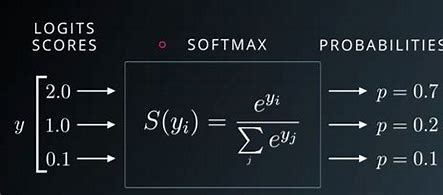

In [ ]:
def evaluation(model, device, test_dl):
  model.eval()
  total = 0.0; correct = 0.0
  with torch.no_grad():
    for data in test_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1))
      _, predicted = torch.max(outputs.data, 1)      
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = correct/total
  return accuracy

# **Main Function**

In [ ]:
def main(epochs=100, batch_size=64, lr=0.002):  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = nn.CrossEntropyLoss()
  model = MLP(784, 128, 64, 10)
  model = model.to(device) # Move model before creating optimizer
  print(model)
  optimizer = Adam(model.parameters(), lr=lr)
  # Data Preparation
  train_dl, valid_dl, test_dl = prepare_data(batch_size)
  # Training
  model = train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl)
  # Evaluation
  acc = evaluation(model, device, test_dl)
  print('Accuracy', acc)
  torch.save(model.state_dict(),"mnist_mlp.pt")

if __name__ == '__main__':
  main()

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)
[1/100, 0/750] loss: 2.3342626
[1/100, 100/750] loss: 0.55659175
[1/100, 200/750] loss: 0.52984095
[1/100, 300/750] loss: 0.45614699
[1/100, 400/750] loss: 0.39827213
[1/100, 500/750] loss: 0.42078948
[1/100, 600/750] loss: 0.26262093
[1/100, 700/750] loss: 0.3557916
trigger times 0
[2/100, 0/750] loss: 0.46947822
[2/100, 100/750] loss: 0.19050598
[2/100, 200/750] loss: 0.30634853
[2/100, 300/750] loss: 0.31489989
[2/100, 400/750] loss: 0.18880095
[2/100, 500/750] loss: 0.22509135
[2/100, 600/750] loss: 0.21663664
[2/100, 700/750] loss: 0.25893584
trigger times 0
[3/100, 0/750] loss: 0.19834882
[3/100, 100/750] loss: 0.20614067
[3/100, 200/750] loss: 0.2242883
[3/100, 300/750] loss: 0.25554702
[3/100, 400/750] loss: 0.22334039
[3/100, 500/7

In [ ]:
%tensorboard --logdir logs/tensorboard

<IPython.core.display.Javascript object>